In [6]:
# Load data

import pandas as pd

url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

# Preview the data
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [7]:
# Preprocess the Data

from sklearn.preprocessing import StandardScaler

# Scale Amount
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Drop Time
df = df.drop(columns=['Time'])

In [8]:
# Split the Data

from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_sm).value_counts())

After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [12]:
# Build and Evaluate Linear Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [17]:
# Train XGBoost Model with Grid Search

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 10, 50, 100]
}

# Base model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit to SMOTE balanced data
random_search.fit(X_train_sm, y_train_sm)

# Best model
best_xgb = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'scale_pos_weight': 100, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2}


In [18]:
# Evaluate the Model

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Report
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.86      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.93      0.85     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9771


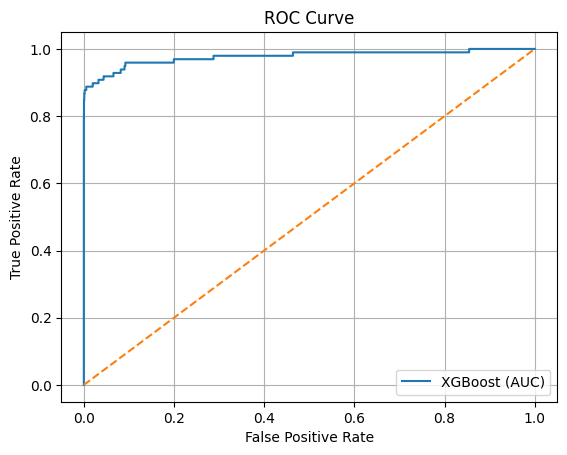

In [19]:
# Plot the ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label='XGBoost (AUC)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()